# In this notebook we test out a Linear Regression as a baseline model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from joblib import Memory
import scipy.stats as st

# Import necessary modules for modeling and preprocessing
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression



In [2]:

train_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\train_cleaned_FE.csv"
df = pd.read_csv(train_file)
df = df.drop(columns=['MRP_by_Outlet_Type']) #We drop this column as it is highly correlated with MRP and had a very low variance for our power transformation



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Item                        8523 non-null   object 
 1   Item_Weight                 8523 non-null   float64
 2   Item_Fat_Content            8523 non-null   object 
 3   Item_Visibility             8523 non-null   float64
 4   Item_Type                   8523 non-null   object 
 5   Item_MRP                    8523 non-null   float64
 6   Outlet                      8523 non-null   object 
 7   Years_Since_Establishment   8523 non-null   int64  
 8   Outlet_Size                 8523 non-null   object 
 9   Outlet_Location_Type        8523 non-null   object 
 10  Outlet_Type                 8523 non-null   object 
 11  Item_Outlet_Sales           8523 non-null   float64
 12  Mean_Sales_Outlet_Type      8523 non-null   float64
 13  Avg_Sales_by_Location_Type  8523 

In [5]:
categorical_cols = ['Item', 'Outlet', 'Outlet_Type','Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']
numerical_cols = ['Item_MRP', 'Item_Weight', 'Item_Visibility','Years_Since_Establishment', 
                  'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type']

In [ ]:
numerical_cols = [col for col in numerical_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]


In [ ]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']


In [10]:
# Ensure numerical_cols and categorical_cols match current dataframe
numerical_cols = [col for col in numerical_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]
print("Columns in X:", X.columns)
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Columns in X: Index(['Item', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet', 'Years_Since_Establishment',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type'],
      dtype='object')
Numerical Columns: ['Item_MRP', 'Item_Weight', 'Item_Visibility', 'Years_Since_Establishment', 'Mean_Sales_Outlet_Type', 'Avg_Sales_by_Location_Type']
Categorical Columns: ['Item', 'Outlet', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Fat_Content', 'Item_Type']


In [ ]:
# RMSE scorer (we use negative RMSE because scikit-learn expects higher scores to be better)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [12]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])
    
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])



In [13]:
# Defining a function to tune a Model with RandomizedSearchCV

def tune_model(model, param_distributions, X, y, preprocessor, n_iter=10, cv=5, random_state=42):
    """
    Build a pipeline with the preprocessor and the given model,
    perform randomized search cross-validation, and return the best estimator.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ], memory=memory)
    
    rsearch = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=rmse_scorer,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rsearch.fit(X, y)
    print(f"Best params for {model.__class__.__name__}: {rsearch.best_params_}")
    print(f"Best CV RMSE for {model.__class__.__name__}: {-rsearch.best_score_:.4f}")
    return rsearch.best_estimator_


In [14]:
# For a regular (non-regularized) LinearRegression model, we only tune the polynomial degree.
linear_params = {
    'preprocessor__num__poly__degree': [1, 2]
}

print("Tuning Linear Regression ...")
linear_model = tune_model(LinearRegression(), linear_params, X, y, preprocessor)


Tuning Linear Regression ...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for LinearRegression: {'preprocessor__num__poly__degree': 2}
Best CV RMSE for LinearRegression: 1220.4701


In [15]:
test_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\test_cleaned_FE.csv"
test_data = pd.read_csv(test_file)
test_data = test_data.drop(columns=['MRP_by_Outlet_Type'],
                              errors='ignore')

predictions_linear = linear_model.predict(test_data)
test_data['Predicted_Item_Outlet_Sales_linear'] = predictions_linear
test_data['Predicted_Item_Outlet_Sales_linear_abs'] = np.abs(predictions_linear)

output_file = r"I:\My Drive\Data Science\Case Comps\Feburary Internship Retail Prediction\submissons\linear_model_poly.csv"
test_data.to_csv(output_file, index=False)
print("Predictions saved to:", output_file)


Predictions saved to: I:\My Drive\Data Science\Case Comps\Feburary Internship Retail Prediction\submissons\linear_model_poly.csv


In [16]:
import joblib  

# Save the trained linear  model
model_path = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Saved Models\linear_poly.pkl"
with open(model_path, "wb") as f:
    joblib.dump(linear_model, f)


# This model gave us a score on the test data set of 1229.3814464918
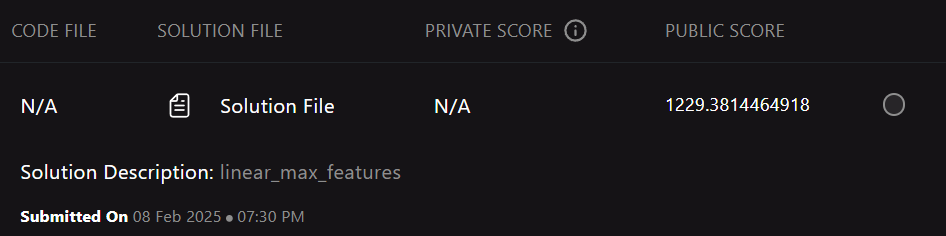